<a href="https://colab.research.google.com/github/jmins33/ml_edu/blob/master/ml_clf/House_Prices2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# House Prices: Advanced Regression Techniques

- 블로그 글과 배운 것을 합침

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.linear_model import SGDRegressor

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 데이터 가져오기
- 구글이랑 빅쿼리에서 데이터 가져오기

In [2]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [3]:
# 구글 인증 라이브러리
from google.colab import auth

# 빅쿼리 관련 라이브러리
from google.cloud import bigquery
from tabulate import tabulate
import pandas as pd

In [8]:
# 훈련 데이터

project_id = 'skilful-tape-286903'
client = bigquery.Client(project=project_id)

df_train = client.query('''
  SELECT 
      * 
  FROM `skilful-tape-286903.houseprice.train`
  ''').to_dataframe()

df_train.shape

(1460, 81)

In [5]:
# 테스트 데이터

project_id = 'skilful-tape-286903'
client = bigquery.Client(project=project_id)

df_test = client.query('''
  SELECT 
      * 
  FROM `skilful-tape-286903.houseprice.test`
  ''').to_dataframe()

df_test.shape

(1459, 80)

# 결측치 채우기
- 결측치 삭제 및 중간값 넣기

- [출처] 집값 예측(2)|작성자 nad__a
- https://blog.naver.com/nad__a/221762534381

In [9]:
df_train= df_train.drop(columns = ['Id','PoolQC','MiscFeature','Alley','PoolArea','Fence'])

In [11]:
df_train['YearRemodAdd']=df_train['YearRemodAdd']-df_train['YearRemodAdd'].min()
df_train['YearBuilt']=df_train['YearBuilt']-df_train['YearBuilt'].min()
df_train['MSSubClass']=df_train['MSSubClass'].astype(str)
df_train['OverallQual']=df_train['OverallQual'].astype(str)
df_train['GarageYrBlt']=df_train['GarageYrBlt'].fillna(df_train['GarageYrBlt'].mean()).astype(int)
df_train['GarageYrBlt']=df_train['GarageYrBlt']-df_train['GarageYrBlt'].min()
df_train['Sold']=df_train['MoSold']+(df_train['YrSold']-df_train['YrSold'].min())*12

df_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,my1stFlrSF,my2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,my3SsnPorch,ScreenPorch,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Sold
0,40,RM,40.0,5400,Pave,Reg,Lvl,AllPub,Corner,Gtl,OldTown,Norm,Norm,1Fam,1Story,6,7,54,54,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,Gd,BrkTil,TA,TA,Mn,LwQ,370,Unf,0,779,1149,GasA,Gd,Y,FuseA,1149,467,0,1616,0,0,2,0,3,1,Gd,5,Typ,0,None,Detchd,26,Unf,1,216,TA,TA,Y,0,0,183,0,0,0,10,2007,WD,Normal,152000,22
1,40,RM,50.0,9100,Pave,Reg,Lvl,AllPub,Inside,Gtl,BrkSide,RRAn,Feedr,1Fam,1Story,5,6,58,10,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,742,742,GasA,TA,Y,FuseA,779,0,156,935,0,0,1,0,2,1,TA,4,Typ,0,None,Detchd,88,Unf,1,308,TA,TA,P,0,0,0,0,0,600,8,2008,WD,Normal,79500,32
2,40,RL,60.0,12144,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,77,0,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,CBlock,TA,TA,No,Rec,375,Unf,0,457,832,GasA,Gd,Y,SBrkr,1036,0,232,1268,0,0,1,0,3,1,TA,6,Typ,1,Gd,Attchd,49,Unf,1,288,TA,TA,Y,0,28,0,0,0,0,9,2009,WD,Normal,133000,45
3,40,RL,NaN,23595,Pave,Reg,Low,AllPub,Inside,Sev,ClearCr,Norm,Norm,1Fam,1Story,7,6,107,29,Shed,WdShake,Plywood,Plywood,None,0.0,Gd,TA,PConc,Gd,TA,Gd,GLQ,1258,Unf,0,74,1332,GasA,TA,Y,SBrkr,1332,192,0,1524,2,0,0,1,0,1,Gd,4,Typ,1,TA,Attchd,79,Fin,2,586,TA,TA,Y,268,0,0,0,0,0,4,2010,WD,Normal,260000,52
4,20,RL,67.0,8877,Pave,Reg,Lvl,AllPub,Inside,Mod,Edwards,Norm,Norm,1Fam,1Story,4,6,66,8,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,ALQ,690,Unf,0,126,816,GasA,Ex,Y,SBrkr,816,0,0,816,1,0,1,0,2,1,TA,3,Typ,1,Gd,Detchd,58,Unf,1,288,Fa,Fa,Y,0,0,0,0,0,0,5,2009,WD,Normal,100000,41


In [13]:
df_train['FullBath']=df_train['FullBath']+df_train['HalfBath']/2
df_train['BsmtFullBath']=df_train['BsmtFullBath']+df_train['BsmtHalfBath']/2

df_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,my1stFlrSF,my2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,my3SsnPorch,ScreenPorch,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Sold
0,40,RM,40.0,5400,Pave,Reg,Lvl,AllPub,Corner,Gtl,OldTown,Norm,Norm,1Fam,1Story,6,7,54,54,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,Gd,BrkTil,TA,TA,Mn,LwQ,370,Unf,0,779,1149,GasA,Gd,Y,FuseA,1149,467,0,1616,0.0,0,2.0,0,3,1,Gd,5,Typ,0,None,Detchd,26,Unf,1,216,TA,TA,Y,0,0,183,0,0,0,10,2007,WD,Normal,152000,22
1,40,RM,50.0,9100,Pave,Reg,Lvl,AllPub,Inside,Gtl,BrkSide,RRAn,Feedr,1Fam,1Story,5,6,58,10,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,742,742,GasA,TA,Y,FuseA,779,0,156,935,0.0,0,1.0,0,2,1,TA,4,Typ,0,None,Detchd,88,Unf,1,308,TA,TA,P,0,0,0,0,0,600,8,2008,WD,Normal,79500,32
2,40,RL,60.0,12144,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,77,0,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,CBlock,TA,TA,No,Rec,375,Unf,0,457,832,GasA,Gd,Y,SBrkr,1036,0,232,1268,0.0,0,1.0,0,3,1,TA,6,Typ,1,Gd,Attchd,49,Unf,1,288,TA,TA,Y,0,28,0,0,0,0,9,2009,WD,Normal,133000,45
3,40,RL,NaN,23595,Pave,Reg,Low,AllPub,Inside,Sev,ClearCr,Norm,Norm,1Fam,1Story,7,6,107,29,Shed,WdShake,Plywood,Plywood,None,0.0,Gd,TA,PConc,Gd,TA,Gd,GLQ,1258,Unf,0,74,1332,GasA,TA,Y,SBrkr,1332,192,0,1524,2.0,0,1.0,1,0,1,Gd,4,Typ,1,TA,Attchd,79,Fin,2,586,TA,TA,Y,268,0,0,0,0,0,4,2010,WD,Normal,260000,52
4,20,RL,67.0,8877,Pave,Reg,Lvl,AllPub,Inside,Mod,Edwards,Norm,Norm,1Fam,1Story,4,6,66,8,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,ALQ,690,Unf,0,126,816,GasA,Ex,Y,SBrkr,816,0,0,816,1.0,0,1.0,0,2,1,TA,3,Typ,1,Gd,Detchd,58,Unf,1,288,Fa,Fa,Y,0,0,0,0,0,0,5,2009,WD,Normal,100000,41


In [15]:
df_train=df_train.drop(['HalfBath','MoSold','YrSold','BsmtHalfBath','my3SsnPorch','EnclosedPorch','ScreenPorch','MiscVal'], axis= 1)
print(df_train.columns)

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'my1stFlrSF', 'my2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'FullBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'OpenPorchSF', 'SaleTy

In [17]:
_str = 'BsmtFinType2'
print(df_train[_str])
print(df_train[_str].isnull().mean())
df_train[_str].value_counts()

0       Unf
1       Unf
2       Unf
3       Unf
4       Unf
       ... 
1455    Unf
1456    Unf
1457    BLQ
1458    Unf
1459    Unf
Name: BsmtFinType2, Length: 1460, dtype: object
0.026027397260273973


Unf    1256
Rec      54
LwQ      46
BLQ      33
ALQ      19
GLQ      14
Name: BsmtFinType2, dtype: int64

# 시각화

In [18]:
k = df_train.corr()
k = k['SalePrice'].to_frame().sort_values(by = 'SalePrice').transpose()

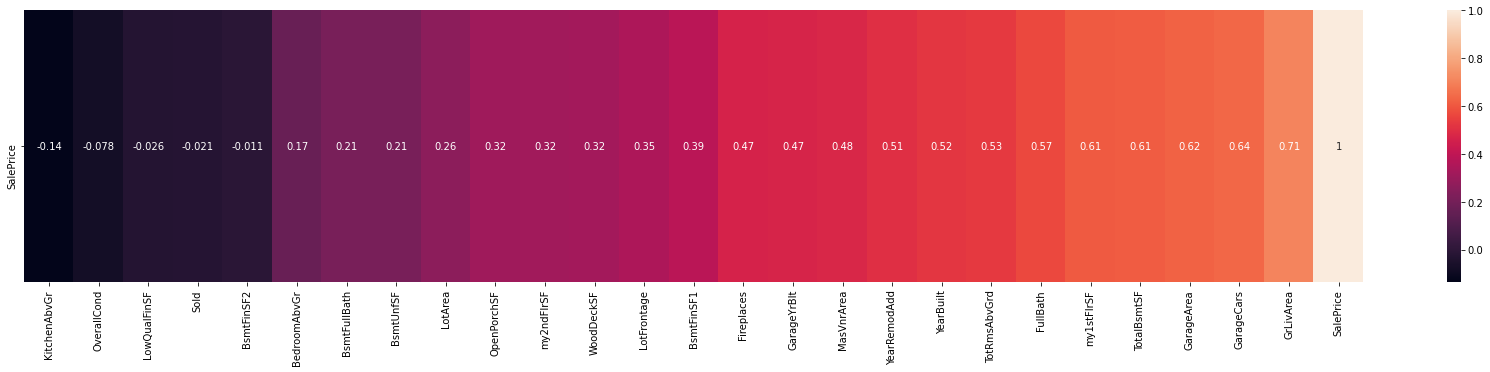

In [19]:
plt.figure(figsize=(30,5))
sns.heatmap(data=k, annot=True)
plt.show()

In [20]:
df_train=df_train.drop(df_train[(df_train['SalePrice']>100000) & (df_train['GrLivArea']>4000)].index)

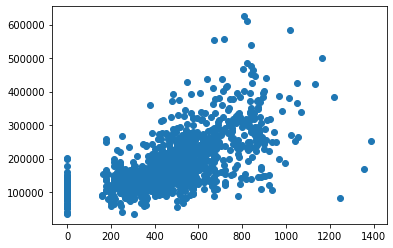

In [21]:
plt.scatter(y=df_train['SalePrice'], x=df_train['GarageArea'])
plt.show()

In [22]:
a = df_train['SalePrice'].value_counts()
print(a)

140000    20
135000    17
145000    14
155000    14
190000    13
          ..
410000     1
62383      1
415298     1
254900     1
194700     1
Name: SalePrice, Length: 660, dtype: int64


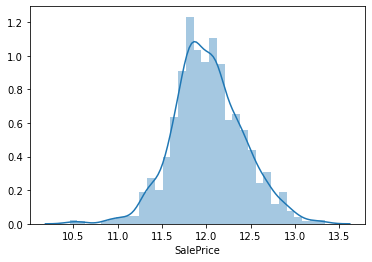

In [23]:
a.index
a.values
sns.distplot(np.log(df_train['SalePrice']))
df_train['SalePrice']=np.log(df_train['SalePrice'])
plt.show()

# 다시 데이터 관리
- df_train 값에서 범주형 데이터 정리

In [24]:
cor = df_train.corr()['SalePrice']
cor = cor.transpose()

In [25]:
# 0,1 값으로..

tonlyNum = df_train.select_dtypes(include = ['float','int32','short','int64'])
onlyObj =df_train.select_dtypes(include = ['object'])

In [26]:
tonlyObj = pd.get_dummies(onlyObj)
tonlyObj

,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,...,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,1,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,1,0,0,...,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,1,...,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,1,0,...,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,1,0,0,...,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1456,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,1,0,...,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1457,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,...,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1458,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,1,0,0,...,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


In [27]:
# 파일 합치기!

tot = pd.concat([tonlyNum,tonlyObj],axis = 1)

# 다시 데이터 관리
- df_test 값에서 범주형 데이터 정리

In [28]:
x_result = df_test
x_result = x_result.drop(columns = ['Id','PoolQC','MiscFeature','Alley','PoolArea','my3SsnPorch','ScreenPorch','Fence','MiscVal'])

In [29]:
x_result['YearRemodAdd']=x_result['YearRemodAdd']-x_result['YearRemodAdd'].min()
x_result['YearBuilt']=x_result['YearBuilt']-x_result['YearBuilt'].min()
x_result['MSSubClass']=x_result['MSSubClass'].astype(str)
x_result['OverallQual']=x_result['OverallQual'].astype(str)
x_result['GarageYrBlt']=x_result['GarageYrBlt'].fillna(x_result['GarageYrBlt'].mean()).astype(int)
x_result['GarageYrBlt']=x_result['GarageYrBlt']-x_result['GarageYrBlt'].min()
x_result['Sold']=x_result['MoSold']+(x_result['YrSold']-x_result['YrSold'].min())*12

x_result['FullBath']=x_result['FullBath']+x_result['HalfBath']/2
x_result['BsmtFullBath']=x_result['BsmtFullBath']+x_result['BsmtHalfBath']/2

x_result=x_result.drop(['HalfBath','MoSold','YrSold','BsmtHalfBath','EnclosedPorch'], axis= 1)

In [30]:
# 0,1 값으로..
tonlyNum1 = x_result.select_dtypes(include = ['float','int32','short','int64'])
onlyObj1 = x_result.select_dtypes(include = ['object'])

In [31]:
tonlyObj1 = pd.get_dummies(onlyObj1)
tonlyObj1

,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,...,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,1,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,1,0,0,...,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,...,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1455,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
1456,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,1,0,1,1,0,0,0,0,1,0,0,...,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1457,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,1,0,1,0,0,0,1,0,0,...,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


In [32]:
# 파일 합치기!
tot1 = pd.concat([tonlyNum1,tonlyObj1],axis = 1)
tot1 = tot1.fillna(tot1.mean())

In [33]:
print(tonlyNum1.shape, tonlyObj1.shape, tot1.shape)

(1459, 26) (1459, 249) (1459, 275)


In [34]:
tt = set(tot.columns)-set(tot1.columns)

for _str in tt:
    tot1[_str]=0
    print(_str,tot1.shape)
    
del tot1['SalePrice']


tt2 = set(tot1.columns)-set(tot.columns)
for _str in tt2:
    tot[_str]=0
    print(_str,tot.shape)


Condition2_RRAe (1459, 276)
Condition2_RRAn (1459, 277)
Exterior1st_ImStucc (1459, 278)
RoofMatl_Membran (1459, 279)
GarageQual_Ex (1459, 280)
Utilities_NoSeWa (1459, 281)
Heating_OthW (1459, 282)
Heating_Floor (1459, 283)
Condition2_RRNn (1459, 284)
SalePrice (1459, 285)
RoofMatl_Roll (1459, 286)
RoofMatl_Metal (1459, 287)
Exterior2nd_Other (1459, 288)
HouseStyle_2.5Fin (1459, 289)
Electrical_Mix (1459, 290)
Exterior1st_Stone (1459, 291)
MSSubClass_150 (1456, 291)


In [35]:
tot = tot.reindex(sorted(tot.columns), axis=1)
tot1 = tot1.reindex(sorted(tot1.columns), axis=1)

y = tot['SalePrice']
x = tot.drop('SalePrice', axis=1)


In [36]:
x=x.fillna(x.mean())
print(x.shape)

(1456, 290)


# 데이터 셋 분리

In [37]:
x_train, x_test, y_train, y_test = train_test_split(x,y,random_state = 253,test_size = 0.01)

#scaler= StandardScaler().fit(x_train)


In [38]:
#model = ElasticNet(alpha = 0.7,l1_ratio=0.9)
model = Ridge(alpha = 0.7)
#model.fit(scaler, y_train)
model.fit(x_train, y_train)

print('{:.3f}'.format(model.score(x_train,y_train)))
print('{:.3f}'.format(model.score(x_test,y_test)))


0.946
0.970


# 결과

In [39]:
output = model.predict(tot1)
output = np.exp(output)

#output[output<0]=0
output1 = pd.DataFrame({"Id":list(range(1461,len(output)+1461)),"SalePrice":output})
output1.to_csv("my.csv",index=False, header= True)